!pip install keras-vggface keras-applications
!pip install -q gdown deepface


In [ ]:
import os
import gdown
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from deepface import DeepFace
from tensorflow.keras.preprocessing import image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random


25-08-04 11:57:14 - Directory /root/.deepface has been created
25-08-04 11:57:14 - Directory /root/.deepface/weights has been created


In [ ]:
from collections import defaultdict
import os
import random

# Updated image directory
image_dir = "/content/drive/MyDrive/DATASET_PIN/IMAGES"

# Dictionary to hold image paths by person name (folder)
person_images = defaultdict(list)

# Loop over each subfolder in image_dir
for person_name in os.listdir(image_dir):
    person_folder = os.path.join(image_dir, person_name)

    if not os.path.isdir(person_folder) or person_name == '.DS_Store':
        continue  # Skip non-folder files like .DS_Store

    for img_file in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_file)

        if os.path.isfile(img_path) and img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            person_images[person_name].append(img_path)

# Keep only persons with at least 7 images
person_images = {label: imgs for label, imgs in person_images.items() if len(imgs) >= 7}

# Prepare train/test splits
train_data = []
test_data = []

for label, imgs in person_images.items():
    random.shuffle(imgs)
    train_imgs = imgs[:5]
    test_imgs = imgs[5:7]
    train_data.extend([(img, label) for img in train_imgs])
    test_data.extend([(img, label) for img in test_imgs])

print("Total identities:", len(person_images))
print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))


Total identities: 105
Training samples: 525
Testing samples: 210


In [ ]:
import pandas as pd
from IPython.display import display

# Create summary for each person
summary = []

for label, imgs in person_images.items():
    total = len(imgs)
    summary.append({
        "Person": label,
        "Total Images": total,
        "Training Images": 5,
        "Testing Images": 2
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Sort alphabetically or as needed
summary_df = summary_df.sort_values(by="Person").reset_index(drop=True)

# Display in chunks of 11
chunk_size = 11
for start in range(0, len(summary_df), chunk_size):
    display(summary_df.iloc[start:start + chunk_size])


Person  Total Images  Training Images  Testing Images
0         pins_Adriana Lima           213                5               2
1         pins_Alex Lawther           152                5               2
2   pins_Alexandra Daddario           225                5               2
3         pins_Alvaro Morte           139                5               2
4          pins_Amanda Crew           117                5               2
5         pins_Andy Samberg           196                5               2
6        pins_Anne Hathaway           208                5               2
7       pins_Anthony Mackie           124                5               2
8        pins_Avril Lavigne           162                5               2
9          pins_Ben Affleck           126                5               2
10          pins_Bill Gates           122                5               2

Person  Total Images  Training Images  Testing Images
11        pins_Bobby Morley           138                5               2
12    pins_Brenton Thwaites           209                5               2
13      pins_Brian J. Smith           102                5               2
14         pins_Brie Larson           169                5               2
15         pins_Chris Evans           166                5               2
16     pins_Chris Hemsworth           159                5               2
17         pins_Chris Pratt           176                5               2
18      pins_Christian Bale           154                5               2
19   pins_Cristiano Ronaldo            98                5               2
20  pins_Danielle Panabaker           181                5               2
21     pins_Dominic Purcell           146                5               2

Person  Total Images  Training Images  Testing Images
22   pins_Dwayne Johnson           141                5               2
23     pins_Eliza Taylor           162                5               2
24   pins_Elizabeth Lail           158                5               2
25    pins_Emilia Clarke           210                5               2
26       pins_Emma Stone           145                5               2
27      pins_Emma Watson           211                5               2
28  pins_Gwyneth Paltrow           187                5               2
29      pins_Henry Cavil           195                5               2
30     pins_Hugh Jackman           179                5               2
31       pins_Inbar Lavi           127                5               2
32      pins_Irina Shayk           156                5               2

Person  Total Images  Training Images  Testing Images
33       pins_Jake Mcdorman           159                5               2
34         pins_Jason Momoa           184                5               2
35   pins_Jennifer Lawrence           180                5               2
36       pins_Jeremy Renner           167                5               2
37      pins_Jessica Barden           141                5               2
38        pins_Jimmy Fallon           113                5               2
39         pins_Johnny Depp           182                5               2
40         pins_Josh Radnor           117                5               2
41    pins_Katharine Mcphee           177                5               2
42  pins_Katherine Langford           226                5               2
43        pins_Keanu Reeves           160                5               2

Person  Total Images  Training Images  Testing Images
44      pins_Krysten Ritter           171                5               2
45   pins_Leonardo DiCaprio           237                5               2
46       pins_Lili Reinhart           150                5               2
47      pins_Lindsey Morgan           169                5               2
48        pins_Lionel Messi            86                5               2
49        pins_Logan Lerman           212                5               2
50    pins_Madelaine Petsch           192                5               2
51     pins_Maisie Williams           193                5               2
52       pins_Maria Pedraza           122                5               2
53  pins_Marie Avgeropoulos           161                5               2
54        pins_Mark Ruffalo           178                5               2

Person  Total Images  Training Images  Testing Images
55      pins_Mark Zuckerberg            95                5               2
56            pins_Megan Fox           209                5               2
57          pins_Miley Cyrus           178                5               2
58   pins_Millie Bobby Brown           191                5               2
59      pins_Morena Baccarin           175                5               2
60       pins_Morgan Freeman           105                5               2
61         pins_Nadia Hilker           133                5               2
62       pins_Natalie Dormer           198                5               2
63      pins_Natalie Portman           166                5               2
64  pins_Neil Patrick Harris           116                5               2
65         pins_Pedro Alonso           125                5               2

Person  Total Images  Training Images  Testing Images
66            pins_Penn Badgley           171                5               2
67              pins_Rami Malek           160                5               2
68        pins_Rebecca Ferguson           178                5               2
69          pins_Richard Harmon           148                5               2
70                 pins_Rihanna           133                5               2
71          pins_Robert De Niro           156                5               2
72        pins_Robert Downey Jr           233                5               2
73     pins_Sarah Wayne Callies           159                5               2
74            pins_Selena Gomez           186                5               2
75  pins_Shakira Isabel Mebarak           154                5               2
76           pins_Sophie Turner           204                5               2

Person  Total Images  Training Images  Testing Images
77       pins_Stephen Amell           159                5               2
78        pins_Taylor Swift           131                5               2
79          pins_Tom Cruise           192                5               2
80           pins_Tom Hardy           198                5               2
81      pins_Tom Hiddleston           181                5               2
82         pins_Tom Holland           189                5               2
83  pins_Tuppence Middleton           133                5               2
84      pins_Ursula Corbero           167                5               2
85    pins_Wentworth Miller           179                5               2
86           pins_Zac Efron           191                5               2
87             pins_Zendaya           138                5               2

Person  Total Images  Training Images  Testing Images
88          pins_Zoe Saldana           186                5               2
89  pins_alycia dabnem carey           211                5               2
90          pins_amber heard           218                5               2
91         pins_barack obama           119                5               2
92       pins_barbara palvin           197                5               2
93        pins_camila mendes           162                5               2
94      pins_elizabeth olsen           221                5               2
95           pins_ellen page           188                5               2
96            pins_elon musk           135                5               2
97            pins_gal gadot           199                5               2
98         pins_grant gustin           183                5               2

Person  Total Images  Training Images  Testing Images
99           pins_jeff bezos           106                5               2
100      pins_kiernen shipka           203                5               2
101       pins_margot robbie           221                5               2
102      pins_melissa fumero           154                5               2
103  pins_scarlett johansson           201                5               2
104           pins_tom ellis           180                5               2

In [ ]:
def extract_features(img_path):
    embedding = DeepFace.represent(img_path=img_path, model_name='Facenet', enforce_detection=False)[0]["embedding"]
    return np.array(embedding)


In [ ]:
from deepface import DeepFace
from contextlib import redirect_stdout
import io

# Build the FaceNet model wrapper
facenet_wrapper = DeepFace.build_model("Facenet")

# Access the internal Keras model
facenet_keras_model = facenet_wrapper.model

# Capture summary into a string buffer
summary_str = io.StringIO()
with redirect_stdout(summary_str):
    facenet_keras_model.summary()

# Split and display the first 15 lines of the summary
summary_lines = summary_str.getvalue().split("\n")
print("\n".join(summary_lines[:50]))  # Change 15 to show more or fewer lines


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5


25-08-04 11:58:34 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


100%|██████████| 92.2M/92.2M [00:00<00:00, 224MB/s]


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)      (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (B  (None, 79, 79, 32)           96        ['Conv2d_1a_3x3[0][0]']       
 atchNormalization)                                                                               
                                                                                                  
 Conv2d_1a_3x3_Activation (  (None, 79, 79, 32)           0         ['Conv2d_1a_

In [ ]:
embeddings = {}

for img_path, label in train_data:
    embedding = extract_features(img_path)
    if label not in embeddings:
        embeddings[label] = []
    embeddings[label].append(embedding)

mean_embeddings = {label: np.mean(vectors, axis=0) for label, vectors in embeddings.items()}


In [ ]:
true_labels = []
pred_labels = []
similarities = []
thresh = 0.60  # Threshold for cosine similarity

for img_path, true_label in test_data:
    feat = extract_features(img_path)
    best_match = None
    best_score = -1
    for person, emb in mean_embeddings.items():
        sim = cosine_similarity([feat], [emb])[0][0]
        if sim > best_score:
            best_score = sim
            best_match = person
    pred = best_match if best_score >= thresh else "Unknown"

    true_labels.append(true_label)
    pred_labels.append(pred)
    similarities.append(best_score)


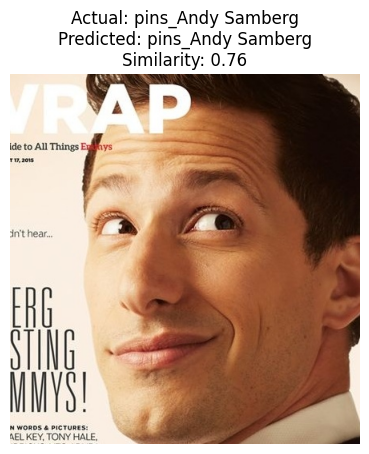

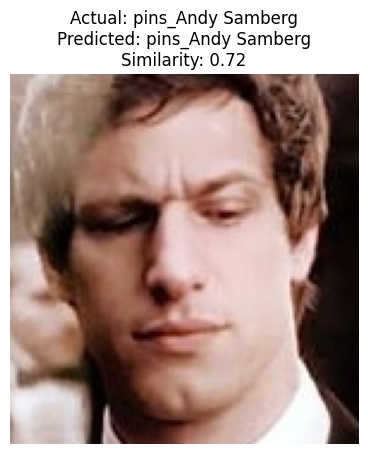

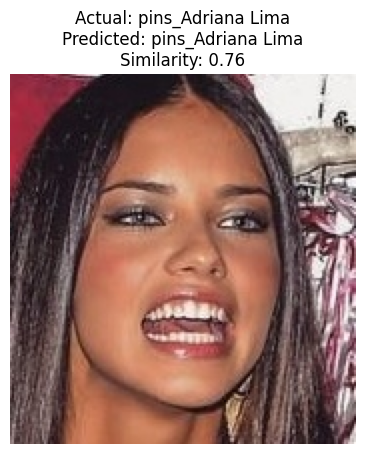

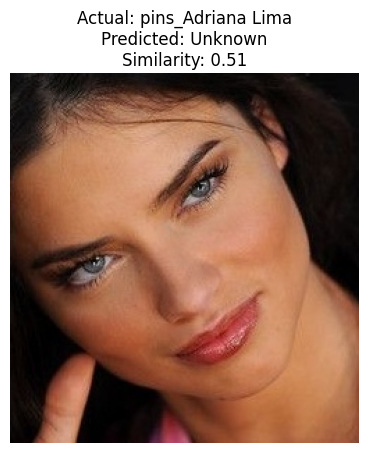

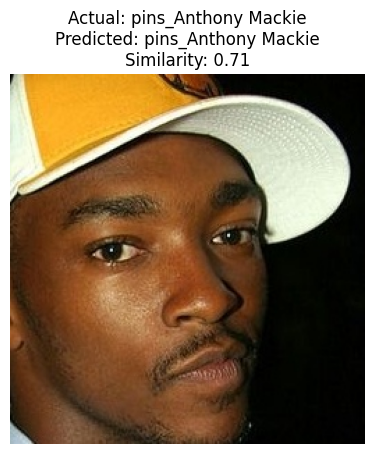

In [ ]:
for i in range(min(5, len(test_data))):
    img_path, true_label = test_data[i]
    pred_label = pred_labels[i]
    sim_score = similarities[i]

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}\nSimilarity: {sim_score:.2f}")
    plt.show()



Classification Report:

                             precision    recall  f1-score   support

                    Unknown       0.00      0.00      0.00         0
          pins_Adriana Lima       1.00      0.50      0.67         2
          pins_Alex Lawther       0.67      1.00      0.80         2
    pins_Alexandra Daddario       1.00      1.00      1.00         2
          pins_Alvaro Morte       1.00      1.00      1.00         2
           pins_Amanda Crew       1.00      1.00      1.00         2
          pins_Andy Samberg       1.00      1.00      1.00         2
         pins_Anne Hathaway       1.00      0.50      0.67         2
        pins_Anthony Mackie       1.00      1.00      1.00         2
         pins_Avril Lavigne       1.00      0.50      0.67         2
           pins_Ben Affleck       0.00      0.00      0.00         2
            pins_Bill Gates       1.00      0.50      0.67         2
          pins_Bobby Morley       0.00      0.00      0.00         2
      pi

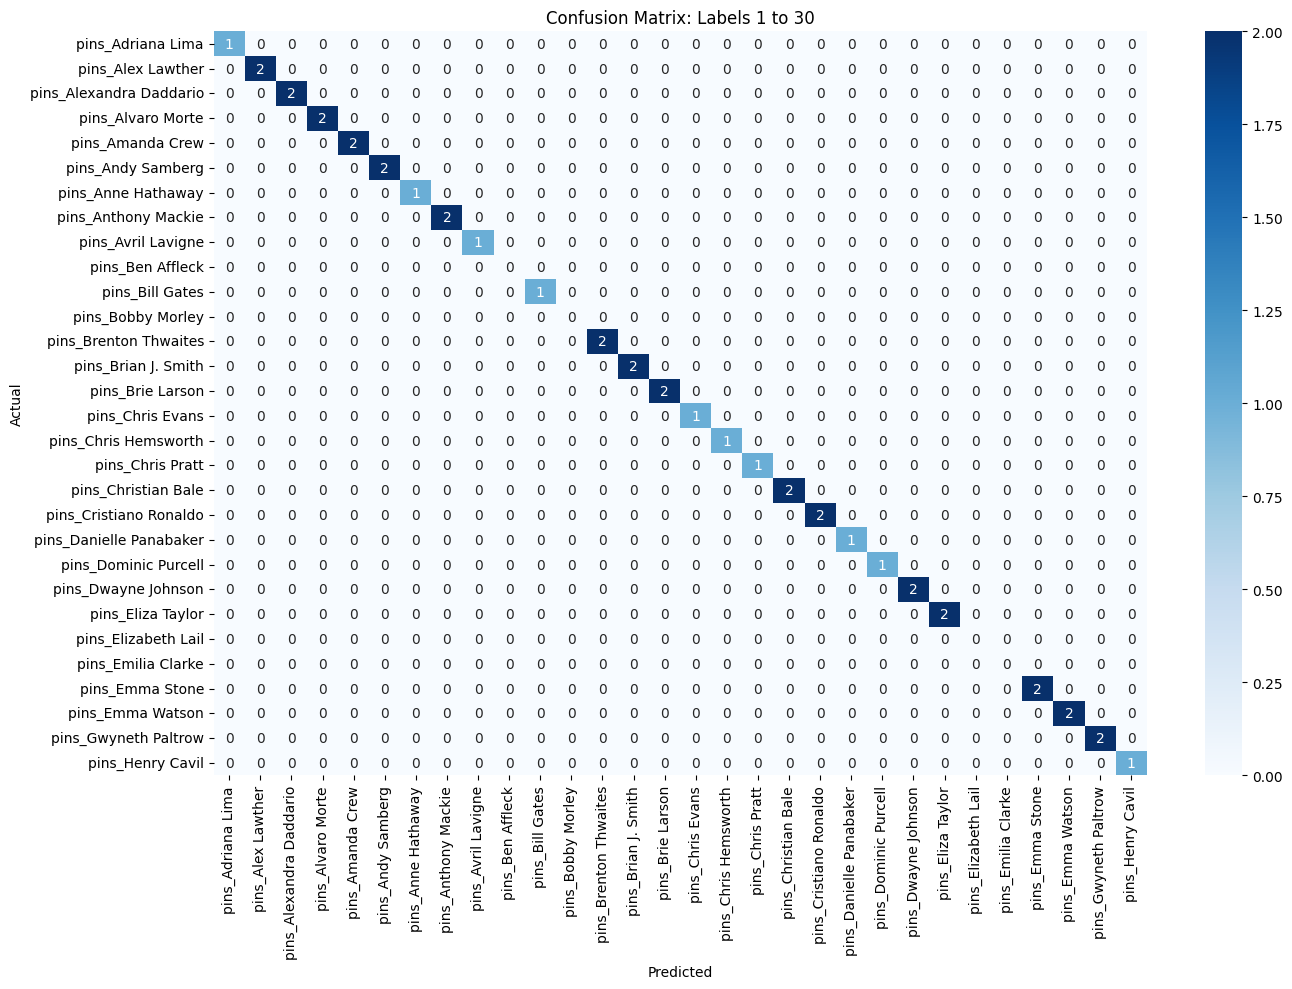

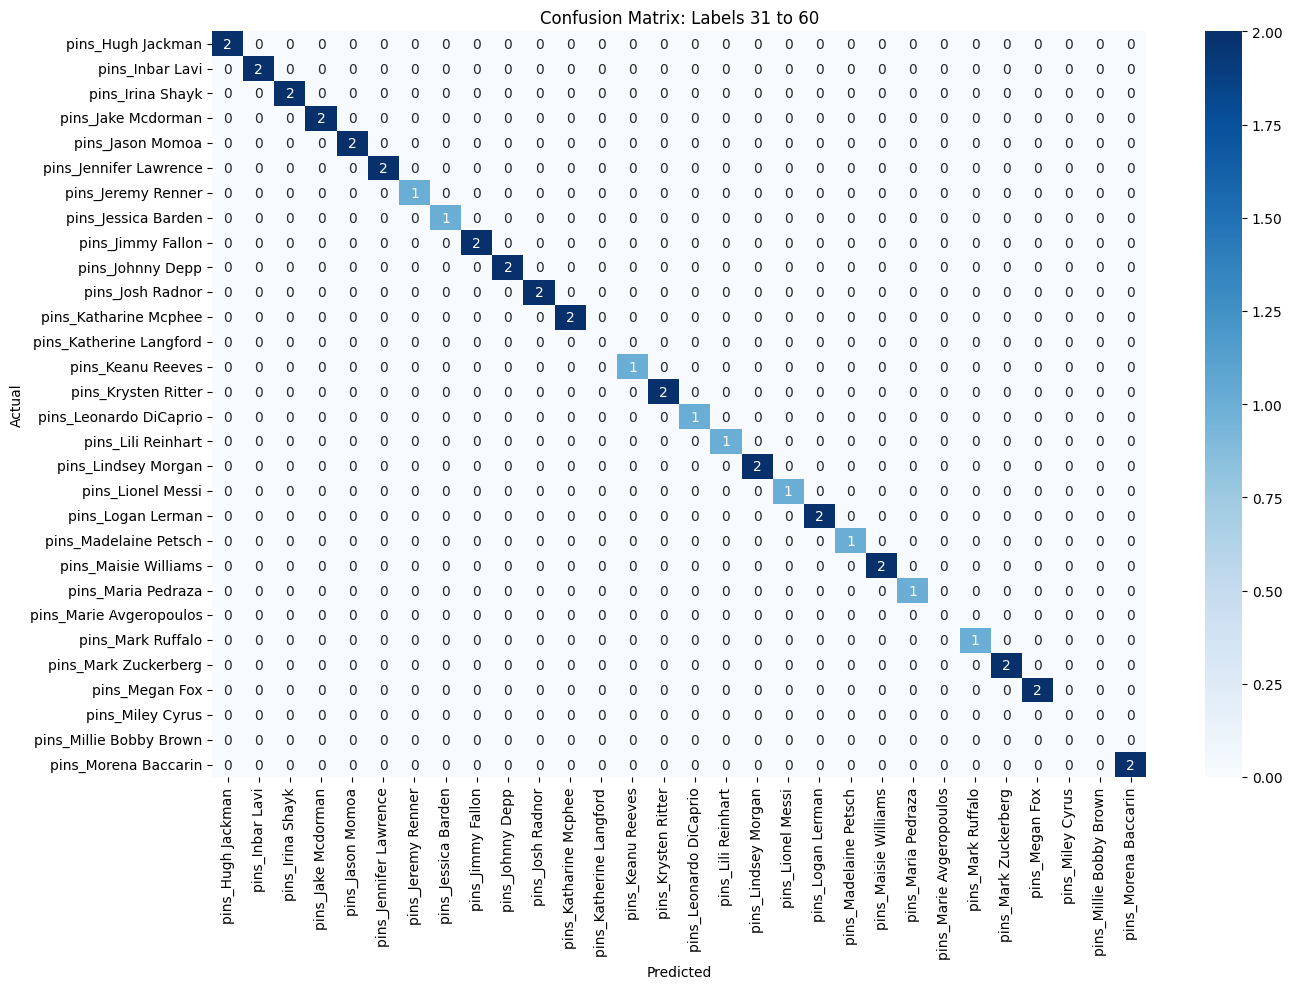

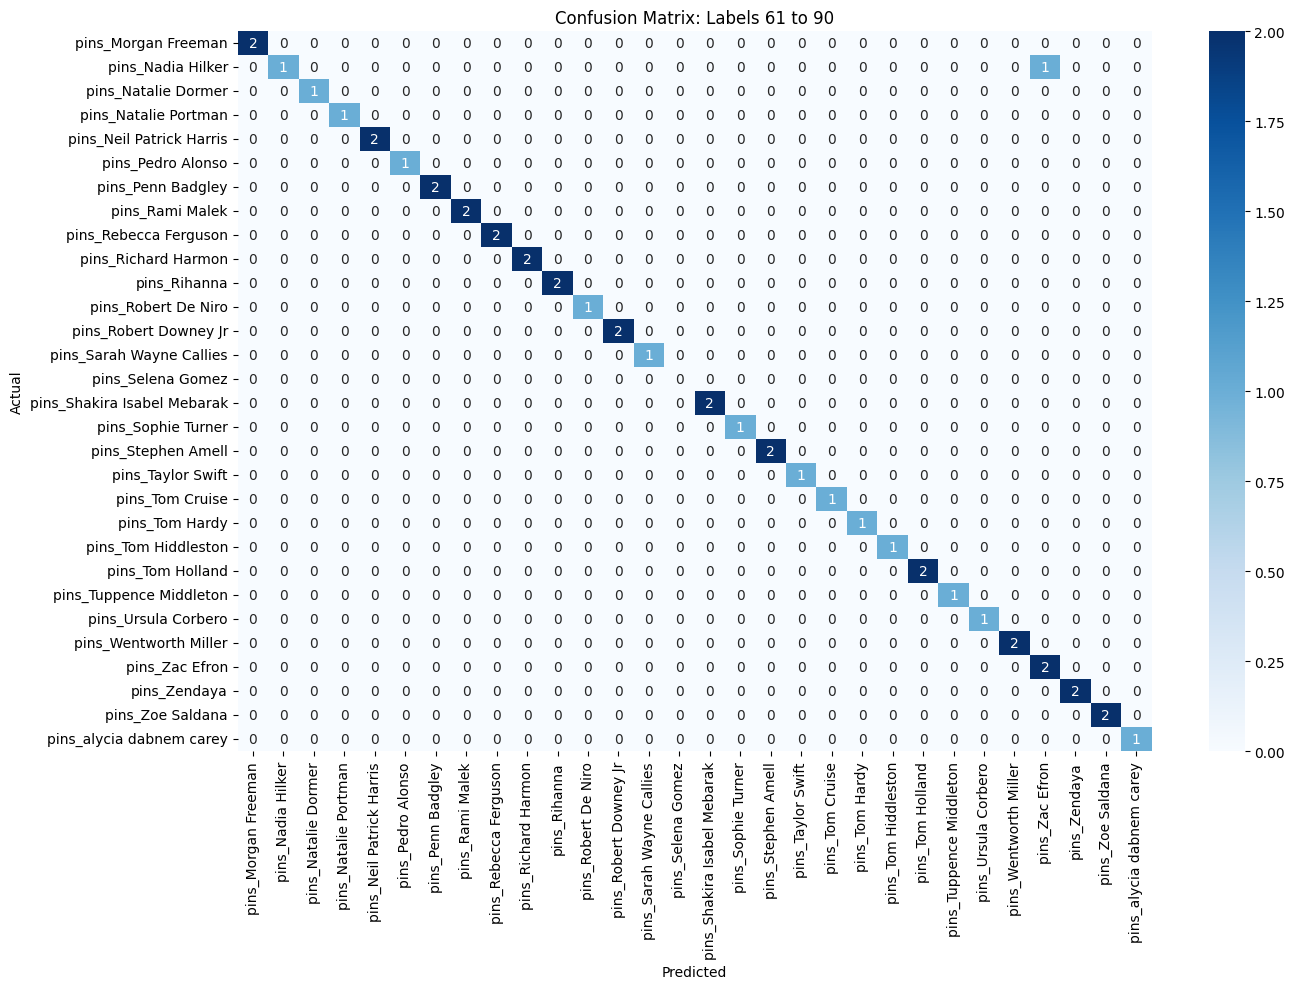

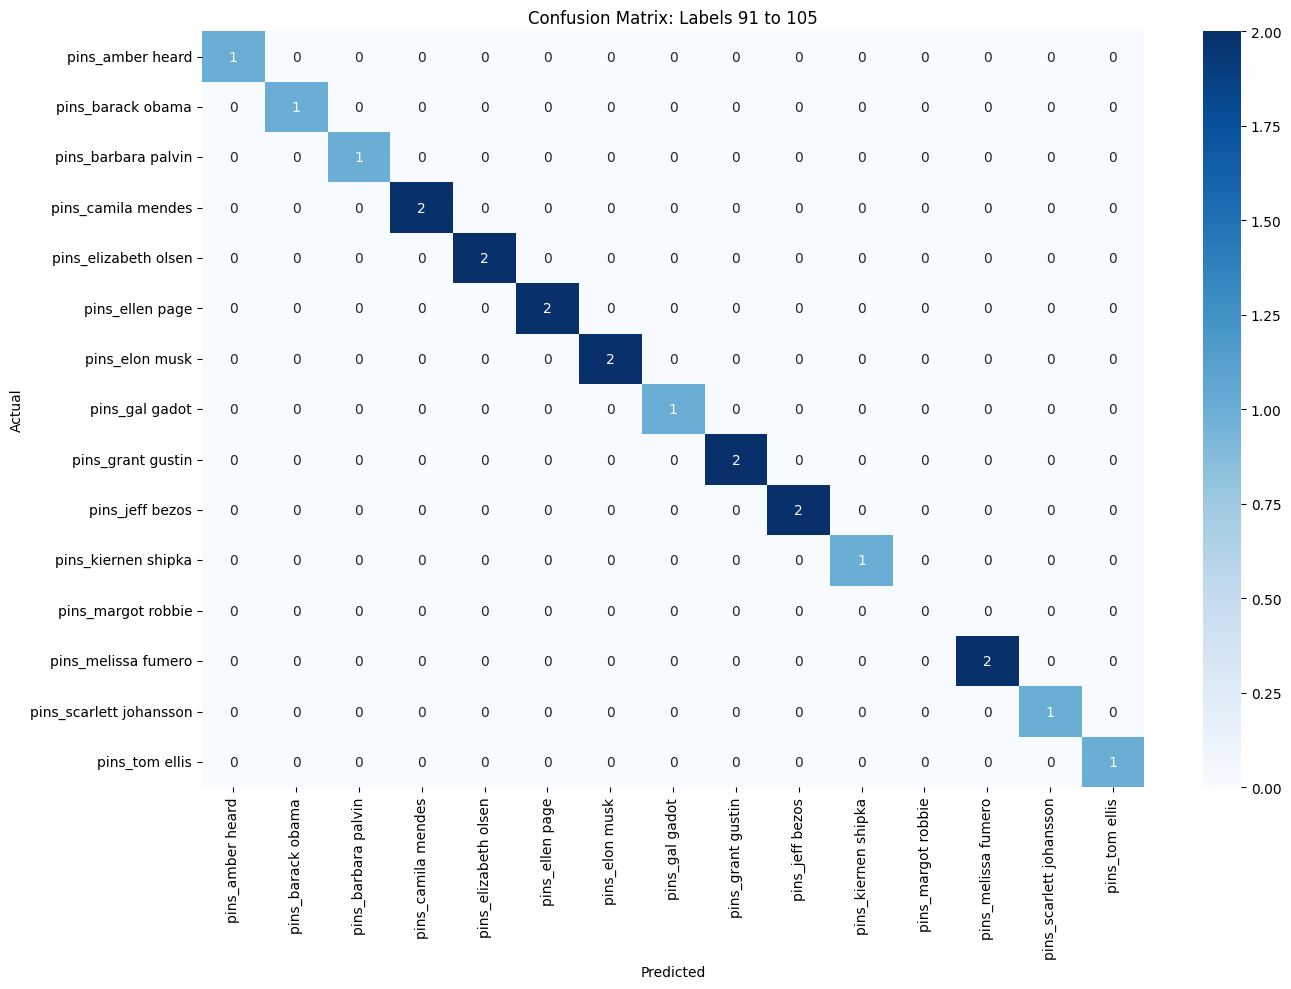


Overall Accuracy: 0.7142857142857143


In [ ]:
from math import ceil

print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels))

# Sort labels
labels_order = sorted(list(set(true_labels)))
cm = confusion_matrix(true_labels, pred_labels, labels=labels_order)

# Number of labels per chunk
chunk_size = 30
num_chunks = ceil(len(labels_order) / chunk_size)

print("\nConfusion Matrices (in chunks of 30 labels):\n")

for chunk_idx in range(num_chunks):
    start = chunk_idx * chunk_size
    end = start + chunk_size

    chunk_labels = labels_order[start:end]

    # Extract sub-matrix
    cm_chunk = confusion_matrix(
        [label if label in chunk_labels else "Other" for label in true_labels],
        [label if label in chunk_labels else "Other" for label in pred_labels],
        labels=chunk_labels
    )

    plt.figure(figsize=(14, 10))
    sns.heatmap(cm_chunk, annot=True, fmt='d',
                xticklabels=chunk_labels, yticklabels=chunk_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: Labels {start + 1} to {min(end, len(labels_order))}')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Final accuracy
print("\nOverall Accuracy:", accuracy_score(true_labels, pred_labels))



Total 'Unknown' predictions: 50



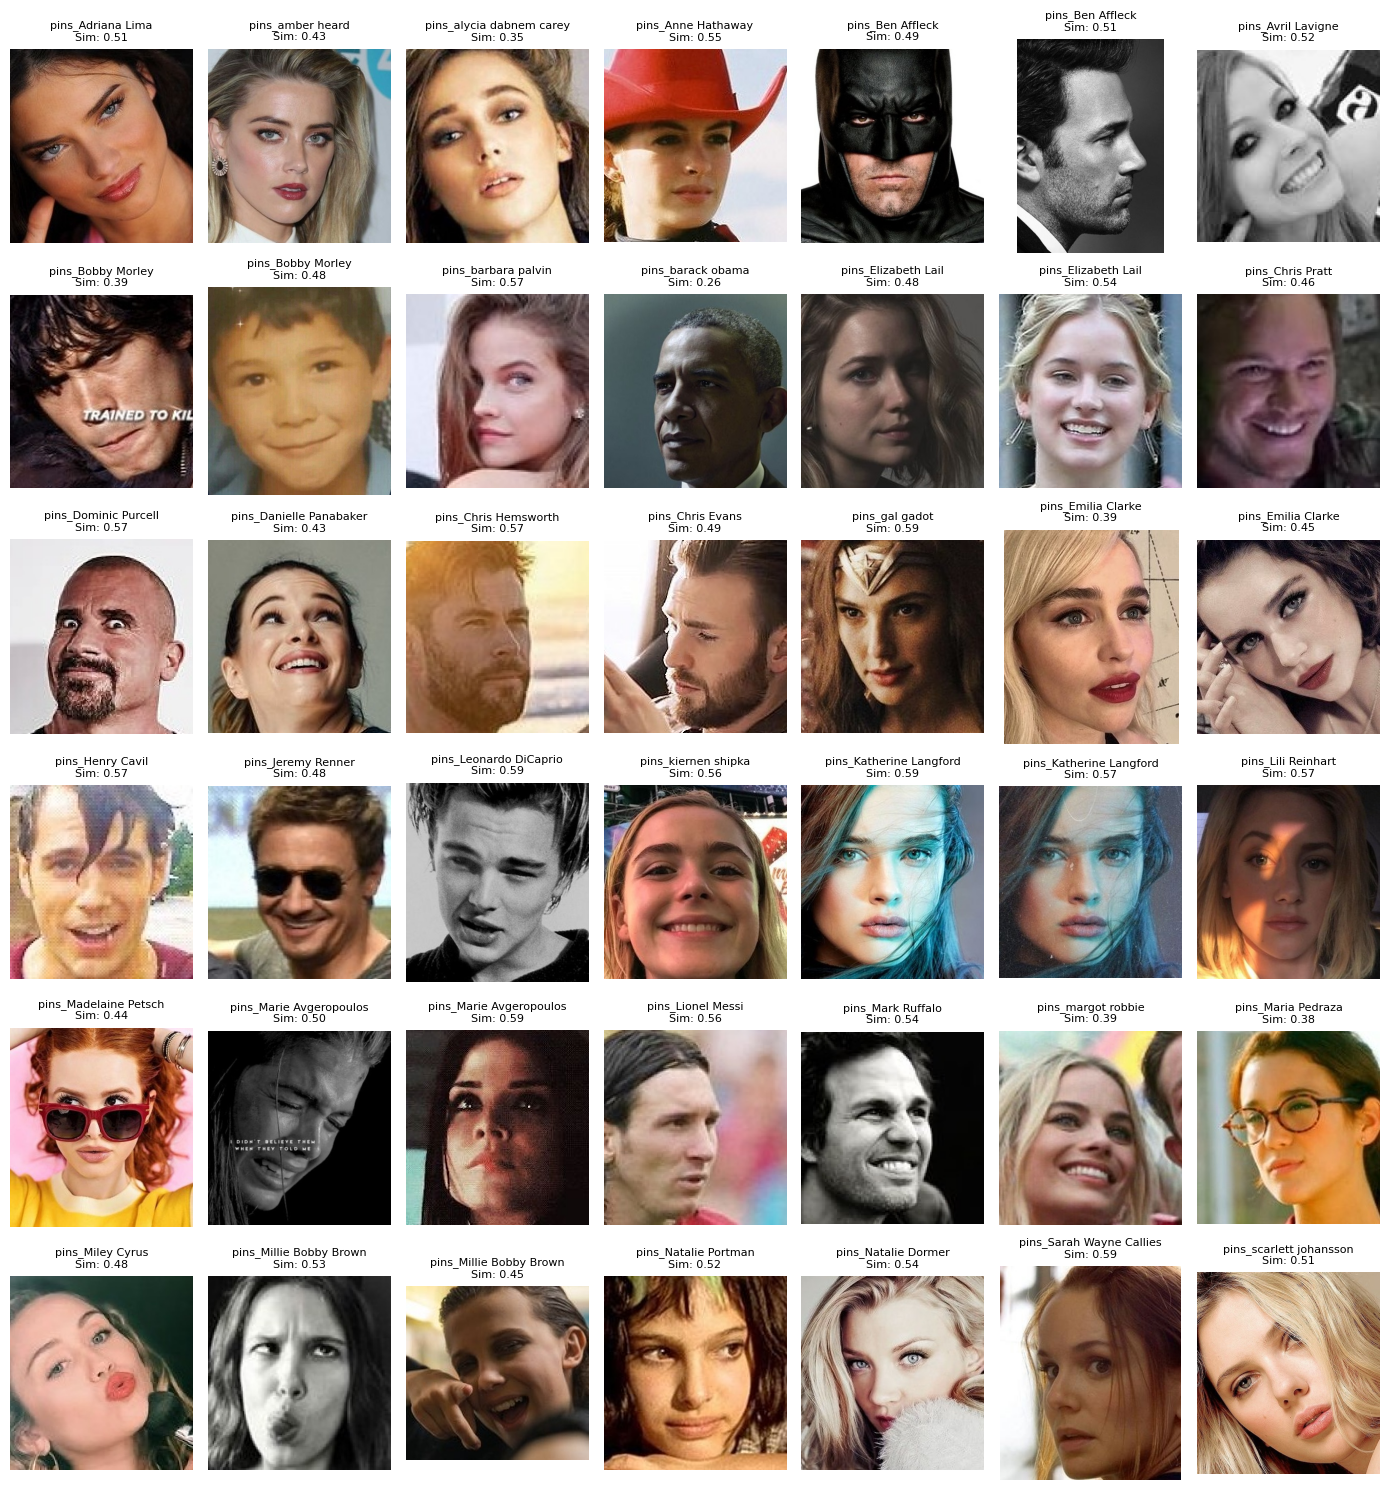

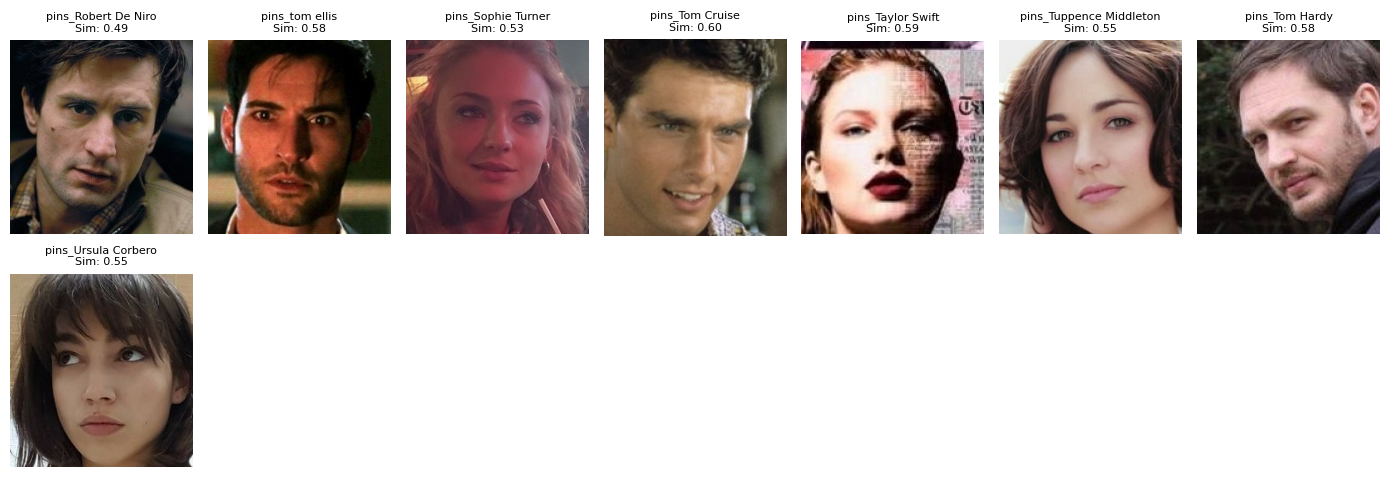

In [ ]:
import matplotlib.pyplot as plt
import math

# Find indices where prediction is "Unknown"
unknown_indices = [i for i, label in enumerate(pred_labels) if label == "Unknown"]

print(f"\nTotal 'Unknown' predictions: {len(unknown_indices)}\n")

# Set number of columns (images per row)
cols = 7
thumb_width, thumb_height = 2, 2.5  # Thumbnail size
batch_size = 42  # Number of images per page (adjust as needed)

for batch_start in range(0, len(unknown_indices), batch_size):
    batch_indices = unknown_indices[batch_start:batch_start + batch_size]

    total_images = len(batch_indices)
    rows = math.ceil(total_images / cols)

    plt.figure(figsize=(cols * thumb_width, rows * thumb_height))

    for idx, grid_pos in zip(batch_indices, range(1, total_images + 1)):
        img_path, true_label = test_data[idx]
        sim_score = similarities[idx]

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, grid_pos)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"{true_label}\nSim: {sim_score:.2f}", fontsize=8)

    plt.tight_layout()
    plt.show()
